<h2>Setting up the System</h2>
Import basic libaries

In [1]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

### Preparing the dataset
We will first prepare the dataset and separate out the guitar images:

1. Divide the folder content into train and validation directories

2. Each directories, create seperate directory for acoustic that contain just acoustic guitars images and seperate directory for electric guitars that contain just electric guitars images
3. Extract the Dataset from the zip file

In [3]:
def main():

    # assigning filename to a variable
    file_name = '/Users/user/Desktop/guitar_project/GuitarDatasetChallenge.zip'

    # opening Zip using 'with' keyword in read mode
    with zipfile.ZipFile(file_name, 'r') as file:
        # printing all the information of archive file contents using 'printdir' method
        print(file.printdir())

        # extracting the files using 'extracall' method
        print('Extracting all files...')
        file.extractall('/Users/user/Desktop/guitar_project/tmp/')
        print('Done!') # check your directory of zip file to see the extracted files

if __name__ == '__main__': main()

File Name                                             Modified             Size
GuitarDatasetChallenge/                        2019-12-05 16:17:28            0
GuitarDatasetChallenge/.DS_Store               2019-12-05 16:18:02         6148
__MACOSX/GuitarDatasetChallenge/._.DS_Store    2019-12-05 16:18:02          120
GuitarDatasetChallenge/acoustic/               2019-12-05 16:17:04            0
GuitarDatasetChallenge/electric/               2019-12-05 16:18:48            0
GuitarDatasetChallenge/acoustic/000026.jpg     2019-07-08 17:16:02         8730
GuitarDatasetChallenge/acoustic/000032.jpg     2019-07-08 17:16:02         6633
GuitarDatasetChallenge/acoustic/000033.jpg     2019-07-08 17:16:02         9954
GuitarDatasetChallenge/acoustic/000027.jpg     2019-07-08 17:16:02        13293
GuitarDatasetChallenge/acoustic/000019.jpg     2019-07-08 17:16:02         6592
GuitarDatasetChallenge/acoustic/000031.jpg     2019-07-08 17:16:02         6569
GuitarDatasetChallenge/acoustic/000025.j

In [79]:
batch_size = 10
img_height = 224
img_width = 224

### load data into our model using images off disk using image_dataset_from_directory.

In [80]:
import tensorflow as tf 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/tmp/GuitarDatasetChallenge/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 95 files belonging to 2 classes.
Using 76 files for training.


In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/tmp/GuitarDatasetChallenge/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 95 files belonging to 2 classes.
Using 19 files for validation.


### Find the classname using the <i>classname attribute</i> on the dataset

In [82]:
class_names = train_ds.class_names
print(class_names)

['acoustic', 'electric']


### Visualize the data

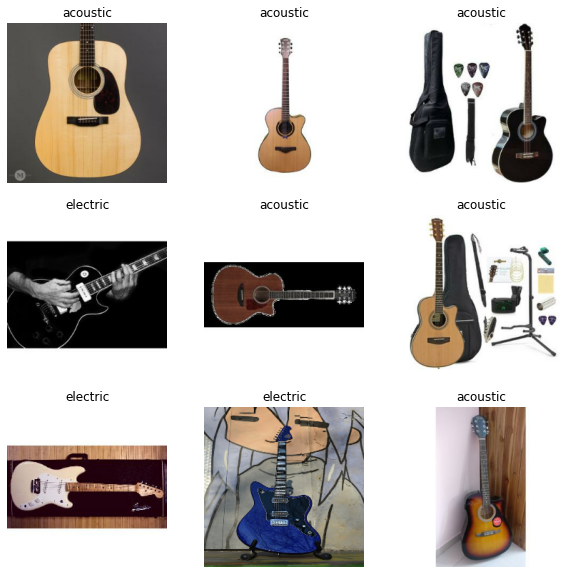

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [84]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 224, 224, 3)
(10,)


In [85]:
image_batch, labels_batch = next(iter(train_ds))

In [86]:
image_batch[0].shape

TensorShape([224, 224, 3])

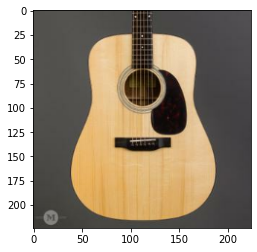

In [87]:
image_batch[0]
plt.imshow(images[0].numpy().astype("uint8"))

###  Create Model (mobilenet_v2)

In [88]:
classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [89]:
import tensorflow_hub as hub
IMAGE_SHAPE = (224, 224, 3)
classifier_layer = hub.KerasLayer(
    classifier_model, input_shape=IMAGE_SHAPE, trainable=False)

In [90]:
classifier_batch = classifier_layer(image_batch)
print(classifier_batch.shape)

(10, 1280)


In [91]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  classifier_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [92]:
predictions = model(image_batch)
predictions

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.00898971, -0.82473373],
       [ 0.16756316, -0.78200316],
       [-0.09575015, -0.27381107],
       [ 2.1378121 , -0.4259424 ],
       [ 0.5932845 , -1.7920864 ],
       [ 2.2485607 , -0.59555405],
       [ 0.18467785, -0.7260168 ],
       [-0.6710209 , -0.7332788 ],
       [ 0.34372482, -0.7400629 ],
       [ 1.3439939 , -1.3523719 ]], dtype=float32)>

### Train the Model
Using compile to figure out the process

In [93]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [94]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
8/8 [==============================] - 8s 450ms/step - loss: 0.7319 - acc: 0.6969 - val_loss: 0.5764 - val_acc: 0.6842
Epoch 2/10
8/8 [==============================] - 3s 316ms/step - loss: 0.5389 - acc: 0.7836 - val_loss: 0.4799 - val_acc: 0.7368
Epoch 3/10
8/8 [==============================] - 3s 297ms/step - loss: 0.3496 - acc: 0.8215 - val_loss: 0.4220 - val_acc: 0.8421
Epoch 4/10
8/8 [==============================] - 3s 308ms/step - loss: 0.3282 - acc: 0.8190 - val_loss: 0.2487 - val_acc: 0.8947
Epoch 5/10
8/8 [==============================] - 3s 319ms/step - loss: 0.1936 - acc: 0.9188 - val_loss: 0.3466 - val_acc: 0.8947
Epoch 6/10
8/8 [==============================] - 3s 287ms/step - loss: 0.1925 - acc: 0.9252 - val_loss: 0.3672 - val_acc: 0.8947
Epoch 7/10
8/8 [==============================] - 3s 291ms/step - loss: 0.1354 - acc: 0.9519 - val_loss: 0.2847 - val_acc: 0.8947
Epoch 8/10
8/8 [==============================] - 3s 291ms/step - loss: 0.1417 - acc: 0.95

### Visualize the result

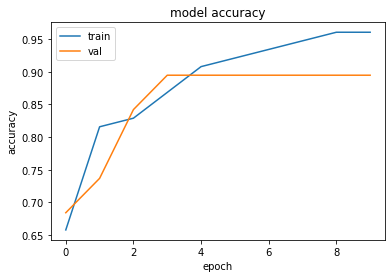

In [95]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

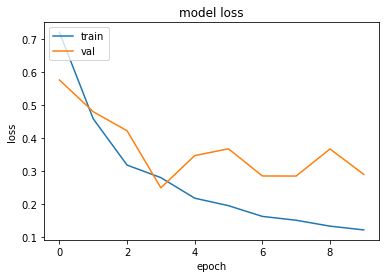

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### check Prediction

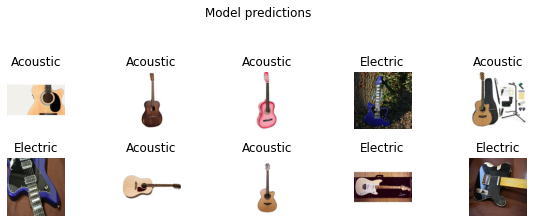

In [97]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
class_names = np.array(class_names)
predicted_label_batch = class_names[predicted_id]




plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(10):
  plt.subplot(6,5,n+1)
  Image = np.array(image_batch[n],np.int32)
  plt.imshow(Image)
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")